# **Stock Sentiment Analysis – Model Evaluation and Testing**

This notebook investigates various machine learning techniques and models for sentiment analysis of stock-related tweets, with the objective of identifying the most effective model for accurate sentiment prediction. Its companion notebook — see TK — applies the selected model to the problem context to generate final predictions.

## 0. Imports

In [97]:
# Standard Library
import os
import re

# Local Scripts
os.chdir("../scripts")

# Constants
from constants import (
    TRAIN_DATA, 
    TEST_DATA, 
    LABELS, 
    DATA_DIR,
    NLTK_DATA,
    GENSIM_DATA
) #type: ignore

# Auxiliaries
from aux_funcs import (
    find_punctuated_tokens, 
    eval_sklearn_model, 
    eval_lstm_model,
    eval_llm_model, 
    eval_transformer
) #type: ignore

# Data Preprocessor
from preprocessor import preprocess #type: ignore

# Local Classes
os.chdir("../classes")
from classes import W2VVectorizer, CLSVectorizer, BERTVectorizer

# Standard Data Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Wordclound Visualization
from wordcloud import WordCloud

# Modelling and modelling metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Transformers
from transformers import AutoTokenizer, AutoModel

# Natural Language ToolKit
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# General Similarity - NLP - Pre-trained Models
from gensim.models import Word2Vec
import gensim.downloader as api

In [98]:
# Download if not data not found
if not os.path.isdir(NLTK_DATA):
    nltk.download('stopwords', download_dir=NLTK_DATA)
    nltk.download('wordnet', download_dir=NLTK_DATA)

nltk.data.path.append(NLTK_DATA)

## 1. Data Loading

In [99]:
train_data = pd.read_csv(TRAIN_DATA)
test_data = pd.read_csv(TEST_DATA)

In [100]:
train_data.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [101]:
test_data.head()

,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."


## 2. Data Exploration

In [102]:
# Checking for missing values
train_data.isna().sum()

text     0
label    0
dtype: int64

There are no missing values in the dataset, so it is safe to proceed.

### 2.1. Text Feature

#### 2.1.1. Word Count

Start by spliting `text` into tokens and analysing the number of tokens in each document.

In [103]:
# Fetch wordcount for each document
train_data['word_count']  = train_data['text'].apply(lambda x: len(str(x).split(" ")))
train_data[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


#### 2.1.2. Descriptive Statistics

In [104]:
train_data['word_count'].describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

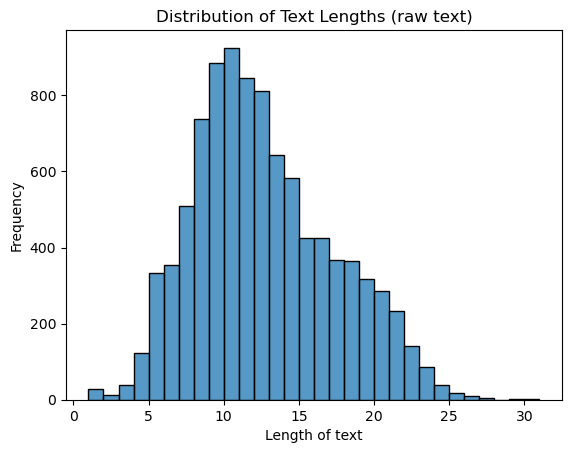

In [105]:
#Plot distribution of text length
sns.histplot(train_data['word_count'], bins=30)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

Considering the table and plot above, it is evident that some rows have very few words. Below, is a deeper exploration of these cases.

In [106]:
# Checking records with 3 words or less
train_data[train_data['word_count'] <= 3]

,text,label,word_count
1858,SASA聚酯选用英威达PTA技术,2,1
3090,Brent +4%,1,2
3593,Honeywell reaffirms guidance,2,3
3943,:),2,1
3945,@MikeCaymanTrades sometimes,2,2
...,...,...,...
8805,SBFGP,2,1
8866,took $PANW #4,2,3
8867,took $PLAY #4,2,3
8878,WBK,2,1


Looking at the records with 3 or less words, most belong to the Neutral category (label = 2). Since there is an overrepresentation of this class in the dataset, below the records above belonging to the Neutral category are excluded.

In [107]:
train_data = train_data[~((train_data['word_count'] <= 3) & (train_data['label'] == 2))]

In [108]:
# Checking word frequency
all_words = ' '.join(train_data['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2331
the    1820
of     1464
-      1390
in     1361
on     1134
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

From the table above, "the" and "The" are both words in the top 10 - this could indicate a beneficial effect of lowercasing the 'text' feature.<br>
Also, "-" is a very common symbol which has no meaning and should be removed from the feature.

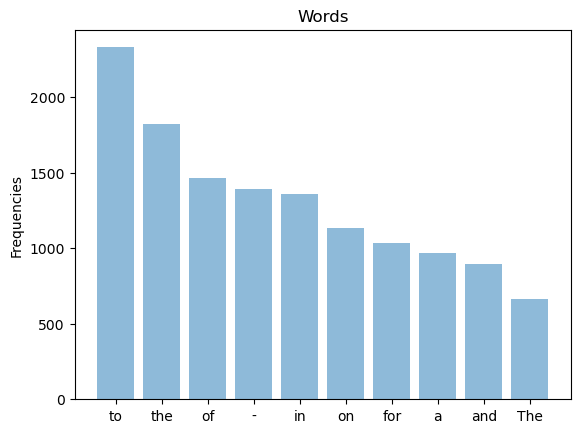

In [109]:
# Plotting the word frequencies count
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')

plt.show()

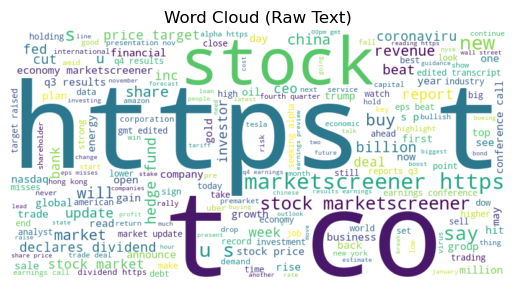

In [110]:
# Create a word cloud from the text feature
raw_text = ' '.join(train_data['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

### 2.2. Target Feature

In [111]:
train_data['label'].value_counts()

label
2    6108
1    1923
0    1442
Name: count, dtype: int64

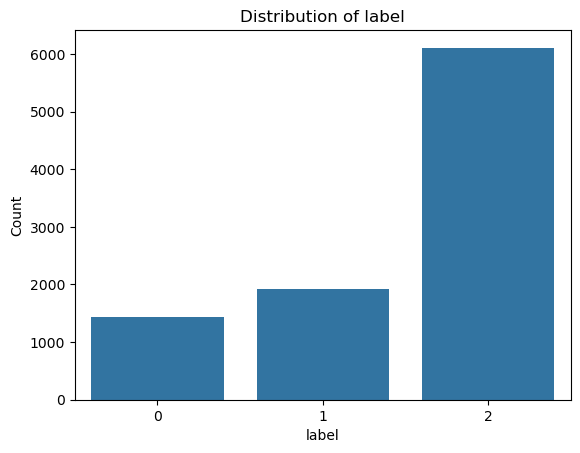

In [112]:
# Visualize distribution of label
sns.countplot(data=train_data, x='label')
plt.title("Distribution of label")
plt.xlabel("label")
plt.ylabel("Count")
plt.show()

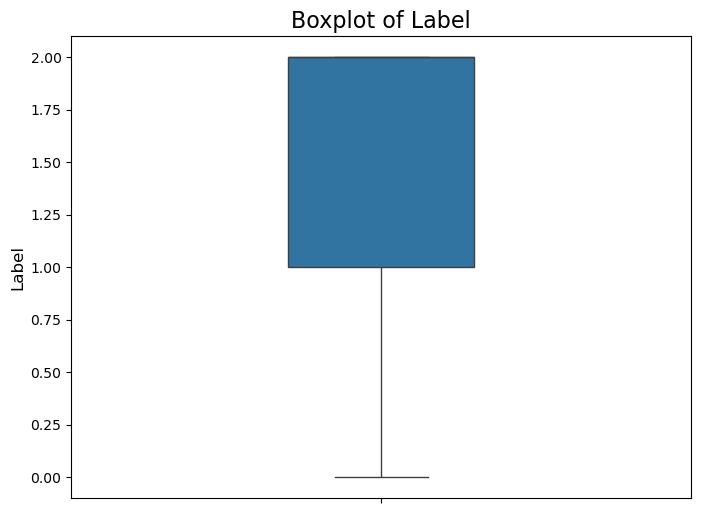

In [113]:
plt.figure(figsize=(8, 6))
sns.boxplot(y='label', data=train_data, width=0.3)

plt.title('Boxplot of Label', fontsize=16)
plt.ylabel('Label', fontsize=12)
plt.xlabel('')

plt.show()

## 3. Data Preprocessing

In [114]:
# Defining the stopwords
stop = set(stopwords.words('english'))

# Initializing Lemmatizer
lemma = WordNetLemmatizer()

# Initializing Stemmer
stemmer = SnowballStemmer('english')

In [115]:
# Apply preprocessing
train_data['text'] = preprocess(
    corpus=train_data['text'],
    to_lower=True,
    keep_ticker=True,
    anonymize=True,
    keep_url=True,
    stopwords=stop,
    lemmatizer=lemma,
    stemmizer=None
)

In [116]:
# # Apply preprocessing
# test_data['text'] = preprocess(
#     corpus=test_data['text'],
#     to_lower=True,
#     keep_ticker=False,
#     anonymize=False,
#     keep_url=False,
#     stopwords=stop,
#     lemmatizer=lemma,
#     stemmizer=None
# )

In [ ]:
# Export preprocessed data
train_data.to_csv(f'{DATA_DIR}/train_preprocessed.csv', sep=',', index=False)
test_data.to_csv(f'{DATA_DIR}/test_preprocessed.csv', sep=',', index=False)

In [ ]:
# Reassign datasets
train_data = pd.read_csv(f'{DATA_DIR}/train_preprocessed.csv')
test_data = pd.read_csv(f'{DATA_DIR}/test_preprocessed.csv')

In [37]:
# Fill missing values with empty string
train_data['text'] = train_data['text'].fillna('')
test_data['text'] = test_data['text'].fillna('')

### 3.1. Rechecking the Plots

In [36]:
all_words = ' '.join(train_data['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

stock       871
market      447
report      401
price       387
result      381
say         373
new         351
earnings    343
share       342
inc         316
Name: count, dtype: int64

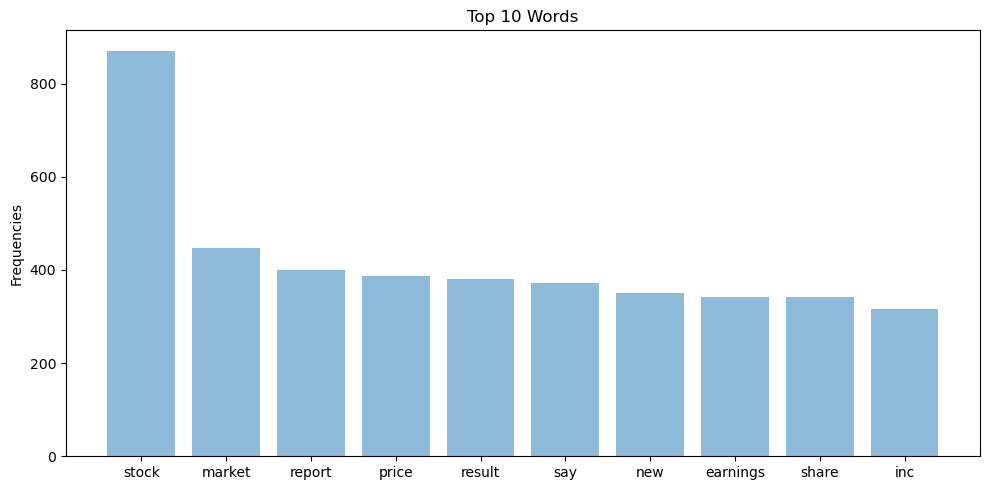

In [38]:
plt.figure(figsize=(10, 5))
x_labels = freq.index[0:10]
values = freq[:10]

plt.bar(x_labels, values, align='center', alpha=0.5)
plt.ylabel('Frequencies')
plt.title('Top 10 Words')
plt.tight_layout()

plt.show()

In [39]:
# Drop rows with encoding errors
exceptions = find_punctuated_tokens(train_data['text'])

pattern = r'(?:' + '|'.join(re.escape(word) for word in exceptions) + r')'

train_data = train_data[~train_data['text'].str.contains(pattern, case=False, na=False)]

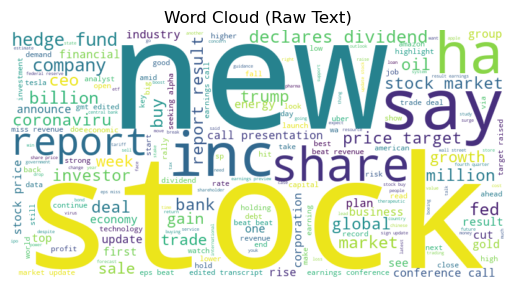

In [40]:
# Word cloud
raw_text = ' '.join(train_data['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

In [41]:
# Define dependent and independent features

# Train
X_train = train_data['text']
y_train = train_data['label']

# Test
X_test = test_data['text']

In [42]:
train_data.text

0                   jpmorgan reel expectation beyond meat
1       nomura point booking weakness carnival royal c...
2        cemex credit suisse morgan weak building outlook
3                               btig research cut neutral
4                           funko slide piper jaffray cut
                              ...                        
9468                       week gainer loser stoxx europe
9469    tupperware brand among consumer gainer unileve...
9470    vtv therapeutic lead healthcare gainer myomo b...
9471                        work xpo pyx amkr among mover
9472                        yndx qd oesx among tech mover
Name: text, Length: 9458, dtype: object

## 4. Feature Engineering

### 4.1 Bag of Words

In [43]:
# Bag of Words
bow = CountVectorizer(
    binary=True  # using binary=True, because working with short text
)

### 4.2 Word2Vec

In [44]:
w2v = W2VVectorizer(
    Word2Vec(
        sentences=train_data.text.apply(lambda x: x.split()).tolist(), #list of lists
        vector_size=5,    # size of the embedding vectors
        window=2,         # context window size
        min_count=1,      # minimum word frequency to include
        sg=1              # 1 for skip-gram; 0 for CBOW
    )
)

### 4.3. DistilBERT

In [45]:
distilbert_model = "distilbert-base-uncased-finetuned-sst-2-english"
distilbert = CLSVectorizer(
    embeddings_model=BERTVectorizer(
        model_name=distilbert_model
    ).embed
)

### 4.4. RoBERTa

In [46]:
roberta_model = "cardiffnlp/twitter-roberta-base-sentiment"
roberta = CLSVectorizer(
    embeddings_model=BERTVectorizer(
        model_name=roberta_model
    ).embed
)

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.5. FinBERT

In [47]:
finbert_model = "yiyanghkust/finbert-tone"
finbert = CLSVectorizer(
    embeddings_model=BERTVectorizer(
        model_name=finbert_model
    ).embed
)

## 5. Modelling

In [ ]:
# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

### 5.1. KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10, metric='cosine', weights='distance')

#### Bag of Words

In [ ]:
# Evaluate the model
y_true_all, y_pred_all = eval_sklearn_model(
    vectorizer=bow
    ,classifier=knn
    ,skf=skf
    ,X_train=X_train
    ,y_train=y_train
)

In [ ]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (KNN Bag of Words)', fontsize=16)
plt.show()

#### Word2Vec

In [ ]:
# Evaluate the model
y_true_all, y_pred_all = eval_sklearn_model(
    vectorizer=w2v
    ,classifier=knn
    ,skf=skf
    ,X_train=X_train
    ,y_train=y_train
)

In [ ]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (KNN Word2Vec)', fontsize=16)
plt.show()

#### DistilBERT

In [ ]:
# Evaluate the model
y_true_all, y_pred_all = eval_sklearn_model(
    vectorizer=distilbert,
    classifier=knn,
    skf=skf,
    X_train=X_train,
    y_train=y_train
)

In [ ]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (KNN DistilBERT)', fontsize=16)
plt.show()

#### RoBERTa

In [ ]:
# Evaluate the model
y_true_all, y_pred_all = eval_sklearn_model(
    vectorizer=roberta,
    classifier=knn,
    skf=skf,
    X_train=X_train,
    y_train=y_train
)

In [ ]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (KNN RoBERTa)', fontsize=16)
plt.show()

#### FinBERT

In [ ]:
# Evaluate the model
y_true_all, y_pred_all = eval_sklearn_model(
    vectorizer=finbert,
    classifier=knn,
    skf=skf,
    X_train=X_train,
    y_train=y_train
)

In [ ]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (KNN FinBERT)', fontsize=16)
plt.show()

### 5.2. LSTM

#### Word2Vec

In [ ]:
y_true_all, y_pred_all, lstm_history = eval_lstm_model(
    X_train=X_train,
    y_train=y_train,
    skf=skf,
    emb_method="word2vec",
    emb_model=w2v,
    device='cpu'
)

In [ ]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (LSTM Word2Vec)', fontsize=16)
plt.show()

In [ ]:
df_list = []

for fold_idx, history in enumerate(lstm_history):
    df_fold = pd.DataFrame(history.history)
    df_fold['epoch'] = range(1, len(df_fold) + 1)
    df_fold['fold'] = fold_idx  # add fold index column
    # Reorder columns so epoch and fold come first (optional)
    cols = ['fold', 'epoch'] + [col for col in df_fold.columns if col not in ('fold', 'epoch')]
    df_fold = df_fold[cols]
    df_list.append(df_fold)

# Concatenate all folds into a single DataFrame
df_history = pd.concat(df_list, ignore_index=True)

# Show head
df_history.head()

In [ ]:
plt.figure(figsize=(12, 8))

epochs = sorted(df_history['epoch'].unique())
train_means = []
val_means = []
train_stds = []
val_stds = []

for epoch in epochs:
    epoch_data = df_history[df_history['epoch'] == epoch]
    train_acc = epoch_data['accuracy']
    val_acc = epoch_data['val_accuracy']
    
    train_means.append(train_acc.mean())
    val_means.append(val_acc.mean())
    train_stds.append(train_acc.std())
    val_stds.append(val_acc.std())

train_means = np.array(train_means)
val_means = np.array(val_means)
train_stds = np.array(train_stds)
val_stds = np.array(val_stds)

plt.plot(epochs, train_means, label='Train Mean Accuracy')
plt.fill_between(epochs, train_means - train_stds, train_means + train_stds, alpha=0.2)

plt.plot(epochs, val_means, label='Val Mean Accuracy')
plt.fill_between(epochs, val_means - val_stds, val_means + val_stds, alpha=0.2)

# Calculate min and max across both train and val means
y_min = min(min(train_means), min(val_means)) - 0.1
y_max = max(max(train_means), max(val_means)) + 0.1

# Prevent y_min from going below 0
y_min = max(y_min, 0)

plt.ylim(y_min, y_max)

plt.title('Mean Model Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### DistilBERT

In [ ]:
y_true_all, y_pred_all, lstm_history = eval_lstm_model(
    X_train=X_train,
    y_train=y_train,
    skf=skf,
    emb_method="transformer",
    emb_model=AutoModel.from_pretrained(distilbert_model),
    tokenizer=AutoTokenizer.from_pretrained(distilbert_model),
    device='cuda'
)

In [ ]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (LSTM Word2Vec)', fontsize=16)
plt.show()

In [ ]:
df_list = []

for fold_idx, history in enumerate(lstm_history):
    df_fold = pd.DataFrame(history.history)
    df_fold['epoch'] = range(1, len(df_fold) + 1)
    df_fold['fold'] = fold_idx  # add fold index column
    # Reorder columns so epoch and fold come first (optional)
    cols = ['fold', 'epoch'] + [col for col in df_fold.columns if col not in ('fold', 'epoch')]
    df_fold = df_fold[cols]
    df_list.append(df_fold)

# Concatenate all folds into a single DataFrame
df_history = pd.concat(df_list, ignore_index=True)

# Show head
df_history.head()

In [ ]:
plt.figure(figsize=(12, 8))

epochs = sorted(df_history['epoch'].unique())
train_means = []
val_means = []
train_stds = []
val_stds = []

for epoch in epochs:
    epoch_data = df_history[df_history['epoch'] == epoch]
    train_acc = epoch_data['accuracy']
    val_acc = epoch_data['val_accuracy']
    
    train_means.append(train_acc.mean())
    val_means.append(val_acc.mean())
    train_stds.append(train_acc.std())
    val_stds.append(val_acc.std())

train_means = np.array(train_means)
val_means = np.array(val_means)
train_stds = np.array(train_stds)
val_stds = np.array(val_stds)

plt.plot(epochs, train_means, label='Train Mean Accuracy')
plt.fill_between(epochs, train_means - train_stds, train_means + train_stds, alpha=0.2)

plt.plot(epochs, val_means, label='Val Mean Accuracy')
plt.fill_between(epochs, val_means - val_stds, val_means + val_stds, alpha=0.2)

# Calculate min and max across both train and val means
y_min = min(min(train_means), min(val_means)) - 0.1
y_max = max(max(train_means), max(val_means)) + 0.1

# Prevent y_min from going below 0
y_min = max(y_min, 0)

plt.ylim(y_min, y_max)

plt.title('Mean Model Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### RoBERTa

In [ ]:
y_true_all, y_pred_all, lstm_history = eval_lstm_model(
    X_train=X_train,
    y_train=y_train,
    skf=skf,
    emb_method="transformer",
    emb_model=AutoModel.from_pretrained(roberta_model),
    tokenizer=AutoTokenizer.from_pretrained(roberta_model),
    device='cuda'
)

In [ ]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (LSTM Word2Vec)', fontsize=16)
plt.show()

In [ ]:
df_list = []

for fold_idx, history in enumerate(lstm_history):
    df_fold = pd.DataFrame(history.history)
    df_fold['epoch'] = range(1, len(df_fold) + 1)
    df_fold['fold'] = fold_idx  # add fold index column
    # Reorder columns so epoch and fold come first (optional)
    cols = ['fold', 'epoch'] + [col for col in df_fold.columns if col not in ('fold', 'epoch')]
    df_fold = df_fold[cols]
    df_list.append(df_fold)

# Concatenate all folds into a single DataFrame
df_history = pd.concat(df_list, ignore_index=True)

# Show head
df_history.head()

In [ ]:
plt.figure(figsize=(12, 8))

epochs = sorted(df_history['epoch'].unique())
train_means = []
val_means = []
train_stds = []
val_stds = []

for epoch in epochs:
    epoch_data = df_history[df_history['epoch'] == epoch]
    train_acc = epoch_data['accuracy']
    val_acc = epoch_data['val_accuracy']
    
    train_means.append(train_acc.mean())
    val_means.append(val_acc.mean())
    train_stds.append(train_acc.std())
    val_stds.append(val_acc.std())

train_means = np.array(train_means)
val_means = np.array(val_means)
train_stds = np.array(train_stds)
val_stds = np.array(val_stds)

plt.plot(epochs, train_means, label='Train Mean Accuracy')
plt.fill_between(epochs, train_means - train_stds, train_means + train_stds, alpha=0.2)

plt.plot(epochs, val_means, label='Val Mean Accuracy')
plt.fill_between(epochs, val_means - val_stds, val_means + val_stds, alpha=0.2)

# Calculate min and max across both train and val means
y_min = min(min(train_means), min(val_means)) - 0.1
y_max = max(max(train_means), max(val_means)) + 0.1

# Prevent y_min from going below 0
y_min = max(y_min, 0)

plt.ylim(y_min, y_max)

plt.title('Mean Model Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### FinBERT

In [ ]:
y_true_all, y_pred_all, lstm_history = eval_lstm_model(
    X_train=X_train,
    y_train=y_train,
    skf=skf,
    emb_method="transformer",
    emb_model=AutoModel.from_pretrained(finbert_model),
    tokenizer=AutoTokenizer.from_pretrained(finbert_model),
    device='cuda'
)

In [ ]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (LSTM Word2Vec)', fontsize=16)
plt.show()

In [ ]:
df_list = []

for fold_idx, history in enumerate(lstm_history):
    df_fold = pd.DataFrame(history.history)
    df_fold['epoch'] = range(1, len(df_fold) + 1)
    df_fold['fold'] = fold_idx  # add fold index column
    # Reorder columns so epoch and fold come first (optional)
    cols = ['fold', 'epoch'] + [col for col in df_fold.columns if col not in ('fold', 'epoch')]
    df_fold = df_fold[cols]
    df_list.append(df_fold)

# Concatenate all folds into a single DataFrame
df_history = pd.concat(df_list, ignore_index=True)

# Show head
df_history.head()

In [ ]:
plt.figure(figsize=(12, 8))

epochs = sorted(df_history['epoch'].unique())
train_means = []
val_means = []
train_stds = []
val_stds = []

for epoch in epochs:
    epoch_data = df_history[df_history['epoch'] == epoch]
    train_acc = epoch_data['accuracy']
    val_acc = epoch_data['val_accuracy']
    
    train_means.append(train_acc.mean())
    val_means.append(val_acc.mean())
    train_stds.append(train_acc.std())
    val_stds.append(val_acc.std())

train_means = np.array(train_means)
val_means = np.array(val_means)
train_stds = np.array(train_stds)
val_stds = np.array(val_stds)

plt.plot(epochs, train_means, label='Train Mean Accuracy')
plt.fill_between(epochs, train_means - train_stds, train_means + train_stds, alpha=0.2)

plt.plot(epochs, val_means, label='Val Mean Accuracy')
plt.fill_between(epochs, val_means - val_stds, val_means + val_stds, alpha=0.2)

# Calculate min and max across both train and val means
y_min = min(min(train_means), min(val_means)) - 0.1
y_max = max(max(train_means), max(val_means)) + 0.1

# Prevent y_min from going below 0
y_min = max(y_min, 0)

plt.ylim(y_min, y_max)

plt.title('Mean Model Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 5.3. RoBERTa Encoder

In [49]:
# Evaluate the model
y_true_all, y_pred_all = eval_transformer(
    transformer=roberta_model
    ,objective='sentiment-analysis'
    ,skf=skf
    ,X_train=X_train
    ,y_train=y_train
)

Device set to use cuda
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [50]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

Overall classification report across all folds:

              precision    recall  f1-score   support

     Bearish     0.4476    0.3171    0.3712      1441
     Bullish     0.4966    0.2248    0.3095      1922
     Neutral     0.6814    0.8459    0.7548      6095

    accuracy                         0.6391      9458
   macro avg     0.5418    0.4626    0.4785      9458
weighted avg     0.6082    0.6391    0.6059      9458



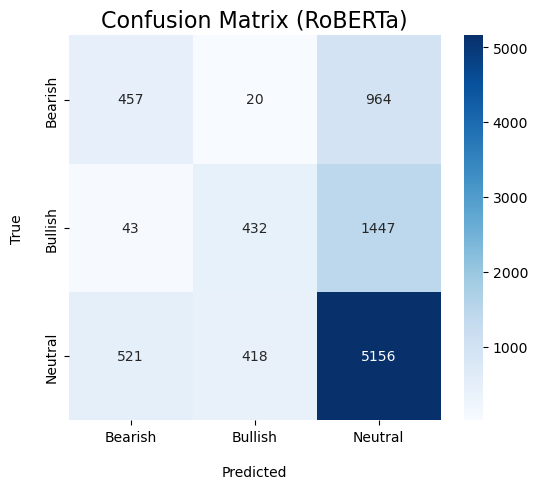

In [51]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (RoBERTa)', fontsize=16)
plt.show()

### 5.4. FinBERT Encoder

In [52]:
# Evaluate the model
y_true_all, y_pred_all = eval_transformer(
    transformer=finbert_model
    ,objective='sentiment-analysis'
    ,skf=skf
    ,X_train=X_train
    ,y_train=y_train
)

Device set to use cuda
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [53]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

Overall classification report across all folds:

              precision    recall  f1-score   support

     Bearish     0.4953    0.4365    0.4640      1441
     Bullish     0.5078    0.4891    0.4983      1922
     Neutral     0.7556    0.7856    0.7703      6095

    accuracy                         0.6721      9458
   macro avg     0.5862    0.5704    0.5775      9458
weighted avg     0.6656    0.6721    0.6683      9458



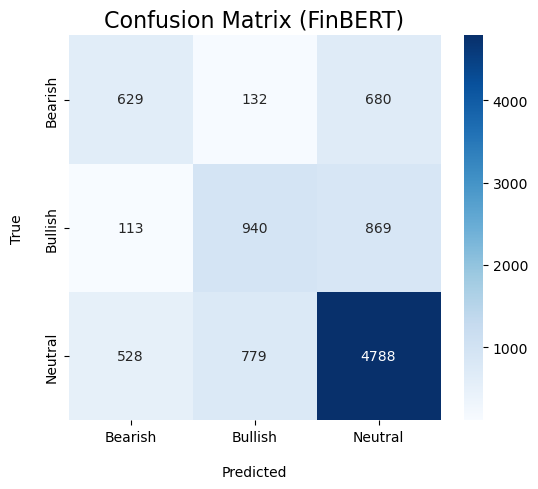

In [54]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (FinBERT)', fontsize=16)
plt.show()

### 5.5. Language Model

In [ ]:
system_message = """
You are a helpful assistant that performs sentiment analysis.

Your task is to analyze the overall sentiment of a given sentence or text.

For each input, classify the sentiment as one of the following single digits ONLY:
- 0: Bearish (negative sentiment)
- 1: Bullish (positive sentiment)
- 2: Neutral sentiment

Respond ONLY with a single digit (0, 1, or 2), with no extra text or explanation.

Examples:
- 'JPMorgan reels in expectations on Beyond Meat' → 0
- 'Dougherty & Company starts at Buy' → 1
- 'Analysts React To FCC Decision On Intelsat C-Band Spectrum Auction' → 2
"""

In [ ]:
# Evaluate the model
y_true_all, y_pred_all = eval_llm_model(
    model="tiiuae/falcon-7b-instruct"
    ,skf=skf
    ,X_train=X_train
    ,y_train=y_train
    ,system_message=system_message
)

In [ ]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (Language Model)', fontsize=16)
plt.show()

In [ ]:
# TODO: Review code; Complete aux_funcs.py 'analyze_sentiment'; Implement extra feature engineering (for extra points); Implement extra classification model